In [30]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import GlobalMaxPooling2D, Input

import pickle

from sklearn.neighbors import NearestNeighbors

In [6]:
#Dataset from kaggle https://www.kaggle.com/datasets/vikashrajluhaniwal/fashion-images

f_vectors = pickle.load(open('f_vectors.pkl', 'rb'))
f_vectors = np.array(f_vectors)
file_names = pickle.load(open('filenames.pkl', 'rb'))

In [2]:
feature_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False,
                                                       input_shape=(224,224,3))
feature_model.trainable = False

preprocess_layer = tf.keras.applications.resnet50.preprocess_input

inputs = Input(shape=(224,224,3))
x = preprocess_layer(inputs)
x = feature_model(x)
output = GlobalMaxPooling2D()(x)

model = tf.keras.Model(inputs, output)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [3]:
def extract(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224,224))
    img = np.array(img)
    img = np.expand_dims(img, 0)
    pred = model.predict(img, verbose=0).flatten()
    return pred/np.linalg.norm(pred)

In [79]:
def recommend(image_path, top_k=5):
    result = extract(image_path, model)

    neighbours = NearestNeighbors(n_neighbors=top_k, algorithm='brute', metric='euclidean')
    neighbours.fit(f_vectors)

    distance, indices = neighbours.kneighbors([result])

    nearest_images = [file_names[i] for i in indices[0][1:]]
    original_image = image_path

    return [original_image] + nearest_images

def display_images(images_path):
    original = cv2.imread(images_path[0])
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    original_res = cv2.resize(original, (200, 200))
    images = images_path[1:]
    images = [cv2.imread(f'Dataset/{image}') for image in images]
    images = [cv2.resize(image, (200, 200)) for image in images]
    images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]

    
    plt.figure(figsize=(4,4))
    plt.imshow(original_res)
    plt.title('Original Image', fontsize=10)
    plt.axis('off')
    plt.show()
    
    fig, ax = plt.subplots(1, len(images), figsize=(20, 20))
    for i, image in enumerate(images):
        ax[i].imshow(image)
        ax[i].axis('off')
    plt.show()


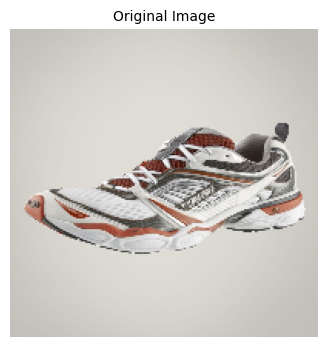

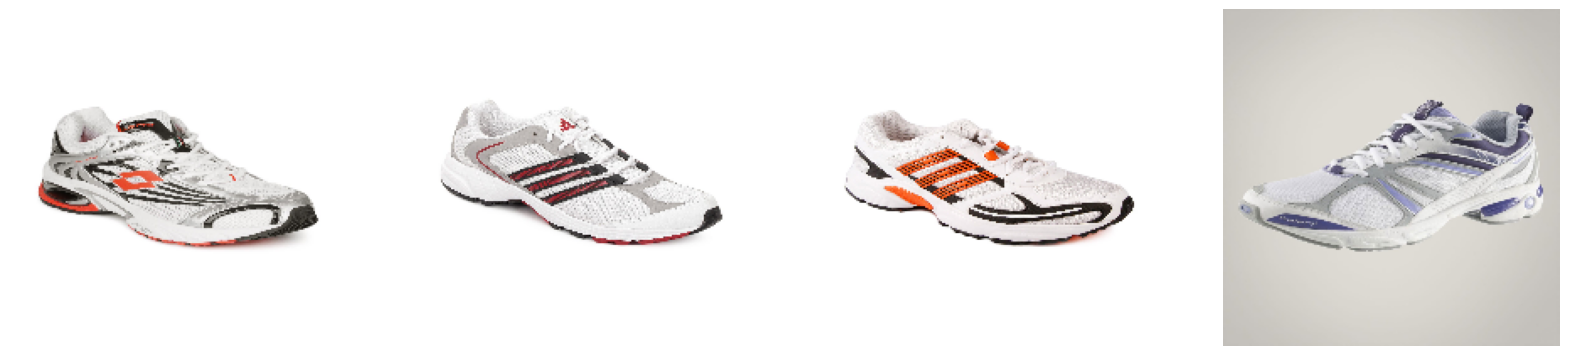

In [88]:
image_path = '5405.jpg'

recommendations = recommend(image_path, top_k=5)
display_images(recommendations)